Importing all nescessary packages.

In [1]:
import pandas as pd
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from google.colab import files
import io
import math
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops

%matplotlib inline
np.random.seed(1)

Downloading & Printing the dataset

In [2]:
url = 'https://raw.githubusercontent.com/MilanBinsMathew/Software-Defect-Prediction-JM1/main/jm1_csv.csv'

In [3]:
df = pd.read_csv(url)
print(df)


         loc  v(g)  ev(g)  iv(g)  ...  total_Op  total_Opnd  branchCount  defects
0        1.1   1.4    1.4    1.4  ...       1.2         1.2          1.4        0
1        1.0   1.0    1.0    1.0  ...       1.0         1.0          1.0        1
2       72.0   7.0    1.0    6.0  ...     112.0        86.0         13.0        1
3      190.0   3.0    1.0    3.0  ...     329.0       271.0          5.0        1
4       37.0   4.0    1.0    4.0  ...      76.0        50.0          7.0        1
...      ...   ...    ...    ...  ...       ...         ...          ...      ...
10880   18.0   4.0    1.0    4.0  ...      30.0        22.0          7.0        0
10881    9.0   2.0    1.0    2.0  ...      19.0        11.0          3.0        0
10882   42.0   4.0    1.0    2.0  ...      59.0        44.0          7.0        0
10883   10.0   1.0    1.0    1.0  ...      21.0        15.0          1.0        0
10884   19.0   3.0    1.0    1.0  ...      31.0        27.0          5.0        0

[10885 rows x 2

Shuffle the dataset and segmenting it

In [12]:
df = df.sample(frac = 1)
rng = np.random.RandomState()
df = df.head(1000)
train = df.sample(frac=0.8, random_state=rng)
test = df.loc[~df.index.isin(train.index)]

train_X = train.copy()
train_Y = train_X.pop('defects')

test_X = test.copy()
test_Y = test_X.pop('defects')
train_Y = pd.Series.to_frame(train_Y)
train_Y = train_Y.T
test_Y = pd.Series.to_frame(test_Y)
test_Y = test_Y.T
train_X = train_X.T
test_X = test_X.T




Cost Function

In [5]:

def cost(logits, labels):

    z = tf.compat.v1.placeholder(tf.float32, name="z")
    y = tf.compat.v1.placeholder(tf.float32, name="y")
    
    cost = tf.nn.sigmoid_cross_entropy_with_logits(logits=z, labels=y)
    
   
    sess = tf.compat.v1.Session()

    cost = sess.run(cost, feed_dict={z: logits, y: labels})
   
    sess.close()
    
    return cost

Creating Place Holders for X and Y

In [6]:
def create_placeholders(n_x, n_y):
  X = tf.compat.v1.placeholder(tf.float32, [n_x, None], name = "X")
  Y = tf.compat.v1.placeholder(tf.float32, [n_y, None], name = "Y")
  return X,Y

Initialize Parameters

In [7]:
def initialize_parameters():
  tf.random.set_seed(1)
  initializer = tf.keras.initializers.GlorotUniform()

  W1= tf.Variable(tf.initializers.GlorotUniform()(shape=(16,21)))
  b1 = tf.Variable(tf.zeros_initializer()(shape=(16,1)))
  W2= tf.Variable(tf.initializers.GlorotUniform()(shape=(8,16)))
  b2 = tf.Variable(tf.zeros_initializer()(shape=(8,1)))
  W3= tf.Variable(tf.initializers.GlorotUniform()(shape=(4,8)))
  b3 = tf.Variable(tf.zeros_initializer()(shape=(4,1)))
  W4= tf.Variable(tf.initializers.GlorotUniform()(shape=(1,4)))
  b4 = tf.Variable(tf.zeros_initializer()(shape=(1,1)))

  parameters = {"W1": W1,
                "b1": b1,
                "W2": W2,
                "b2": b2,
                "W3": W3,
                "b3": b3,
                "W4": W4,
                "b4": b4}
  return parameters

Forward Propagation

In [8]:
def forward_propagation(X, parameters):
  W1 = parameters['W1']
  b1 = parameters['b1']
  W2 = parameters['W2']
  b2 = parameters['b2']
  W3 = parameters['W3']
  b3 = parameters['b3']
  W4 = parameters['W4']
  b4 = parameters['b4']
  
  Z1 = tf.add(tf.matmul(W1,X), b1)
  A1 = tf.nn.relu(Z1)
  Z2 = tf.add(tf.matmul(W2,A1), b2)
  A2 = tf.nn.relu(Z2)
  Z3 = tf.add(tf.matmul(W3,A2), b3)
  A3 = tf.nn.relu(Z3)
  Z4 = tf.add(tf.matmul(W4,A3), b4)
  
  return Z4  

Compute End Cost

In [9]:
def compute_cost(Z4, Y):
  logits = tf.transpose(Z4)
  labels = tf.transpose(Y)

  cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logits, labels = labels))

  return cost

Final Implementation Model

In [20]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001, num_epochs = 1500, print_cost = True):
  ops.reset_default_graph()
  tf.random.set_seed(1)
  seed = 3

  (n_x,m) = X_train.shape
  n_y = Y_train.shape[0]
  costs=[]
  X,Y = create_placeholders(n_x, n_y)

  parameters = initialize_parameters()

  with tf.GradientTape() as tape:
    Z4 = forward_propagation(X, parameters)
    cost = compute_cost(Z4,Y)

  
  optimizer = tf.keras.optimizers.Adam().minimize(cost, var_list = parameters, tape = tape)

  init = tf.compat.v1.global_variables_initializer()

  with tf.compat.v1.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
      epoch_cost = 0
      seed = seed+1
      _ , batch_cost = sess.run([optimizer, cost], feed_dict={X: X_train, Y: Y_train})
      
      epoch_cost += batch_cost

      if print_cost == True and epoch % 100 == 0:
        print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
      if print_cost == True and epoch % 5 == 0:
        costs.append(epoch_cost)
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    parameters = sess.run(parameters)
    print("Parameters have been trained")

    correct_prediction = tf.equal(tf.argmax(Z4), tf.argmax(Y))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    
    print("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
    print("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))

    return parameters

Running the model

Cost after epoch 0: 399.417603
Cost after epoch 100: 6.257182
Cost after epoch 200: 6.393854
Cost after epoch 300: 1.598771
Cost after epoch 400: 4.445578
Cost after epoch 500: 13.278195
Cost after epoch 600: 7.864132
Cost after epoch 700: 5.592608
Cost after epoch 800: 1.822863
Cost after epoch 900: 6.720356
Cost after epoch 1000: 4.014119
Cost after epoch 1100: 16.384558
Cost after epoch 1200: 6.684209
Cost after epoch 1300: 2.321963
Cost after epoch 1400: 2.171967


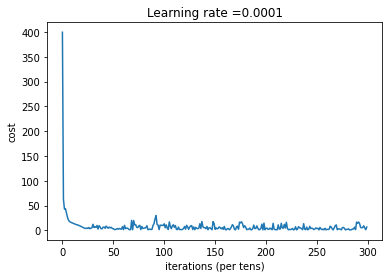

Parameters have been trained
Train Accuracy: 1.0
Test Accuracy: 1.0


In [21]:

parameters = model(train_X, train_Y, test_X, test_Y)